# Machine Learning On Tennis Data
## Contents
>* [Setup](#0)
>* [XGBOOST](#1)

## 0 - Setup <a class="anchor" id="0"></a>

In [1]:
import pandas as pd
import numpy as np
import pickle
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import randint

In [2]:
f = open('train_test_split.pkl', 'rb')
X_train, X_test, y_train, y_test = pickle.load(f)

## Model Fitting

I ran the whole of sklearn in a google colab (no hyperparam tuning) to give us an estimate of the success of each model type
results = {
"Decision Tree":0.66,
"Random Forest":0.53,
"Neural Net":0.67,
"AdaBoost":0.67,
"Naive Bayes":0.60,
"QDA":0.52,
"Nearest Neighbors":0.60,
"Linear SVM":0.67,
"RBF SVM":0.51,
"Gaussian Process":0.51
}<br>

I propose we look at XGBoost (tree methods), Neural nets & SVM

### XGBoost <a class="anchor" id="1"></a>

In [3]:
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

In [4]:
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic')

In [5]:
## The cube of hyperparams to search over
param_dist = {
              'n_estimators': stats.randint(150, 1000),
              'learning_rate': stats.uniform(0.01, 0.6),
              'subsample': stats.uniform(0.3, 0.9),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.9),
              'min_child_weight': [1, 2, 3, 4]
             }

In [6]:
param = {'colsample_bytree': 0.8346974684768449, 'learning_rate': 0.036831995668043196, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.6974361497748996, 'objective': 'binary:logistic'}
epochs = 15

In [7]:
bst = xgb.train(param, d_train, epochs)

[23:34:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [8]:
preds = bst.predict(d_test)
pred_df = pd.DataFrame({'y': y_test,'pred': preds})

In [9]:
acc_list = []
freq_list = []
for p_threshold in np.linspace(0.5,0.75,100):
    condifent_preds = pred_df[(pred_df.pred>p_threshold) | (pred_df.pred<(1-p_threshold))]
    accuracy = accuracy_score(condifent_preds.y,(condifent_preds.pred > 0.5).astype('uint8'))
    acc_list.append(accuracy)
    freq_list.append(condifent_preds.shape[0])
    
freq_list = np.array(freq_list); acc_list = np.array(acc_list)
freq_list = freq_list/len(preds)

K:\Programs\Anaconda\lib\site-packages\numpy\lib\function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
K:\Programs\Anaconda\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


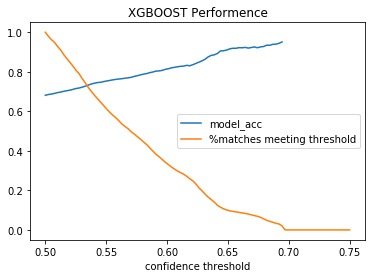

In [10]:
plt.plot(np.linspace(0.5,0.75,100),acc_list,label='model_acc')
plt.plot(np.linspace(0.5,0.75,100),freq_list,label='%matches meeting threshold')
plt.xlabel('confidence threshold')
plt.title('XGBOOST Performence')
plt.legend()

In [11]:
bst.save_model('xgb_model.json')

In [12]:
pickle.dump(bst, open("bst.pickle.dat", "wb"))